<a href="https://colab.research.google.com/github/riskydav/Orbit-Future-Academy/blob/main/49_Time_Series_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kamis, 18 November 2021 (LSTM)

REFERENSI

- [tau-data.id : data, jurnal/research, education](https://tau-data.id/)
- https://keras.io/api/layers/recurrent_layers/
- RNN : https://keras.io/api/layers/recurrent_layers/rnn/
- GRU : https://keras.io/api/layers/recurrent_layers/gru/
- SimpleRNN : https://keras.io/api/layers/recurrent_layers/simple_rnn/#simplernn-class
- Generative Adversarial Networks (GANs) : https://github.com/soumith/ganhacks


### Import Modul Standar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

Import Data Konsumsi Energi dari American Electric Power (AEP) https://raw.githubusercontent.com/khsieh18/Time-Series/master/AEP_hourly.csv 


Data konsumsi energi dari American Electric Power (AEP) diimport menggunakan pandas
Karena format datanya csv maka untuk mengimportnya menggunakan pd.read_csv()
Setelah diimport dan simpan dalam variabel df, kita coba lihat 10 data teratas menggunakan df.head()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/khsieh18/Time-Series/master/AEP_hourly.csv')
df.head(10)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


Melihat informasi singkat dari dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


Dari informasi singkat di atas, kita dapat mengetahui bahwa df terdiri dari 121273 baris.
Selain itu, pada kolom Datetime, tipe datanya masih berupa object (string) sehingga perlu diubah menjadi tipe data datetime dengan cara berikut.

In [4]:
# merubah tipe data object to datetime
df['Datetime'] = df['Datetime'].astype('datetime64')

# melihat tipe data dataframe
print(df.dtypes)

Datetime    datetime64[ns]
AEP_MW             float64
dtype: object


Perhatikan waktu terawal dari kolom Datetime dan 5 data teratas dari df


In [5]:
print('waktu terawal dari kolom Datetime adalah:', df['Datetime'].min())
df.head()

waktu terawal dari kolom Datetime adalah: 2004-10-01 01:00:00


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Dapat kita lihat bahwa waktu pada baris pertama dari kolom tidak sama dengan waktu terawalnya.
Maka dari itu perlu kita urutkan df berdasarkan Datetime menggunakan df.sort_values().


In [6]:
# mengurutkan data berdasarkan waktu
df.sort_values('Datetime', inplace=True, ignore_index=True)
df.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


Plot Data df

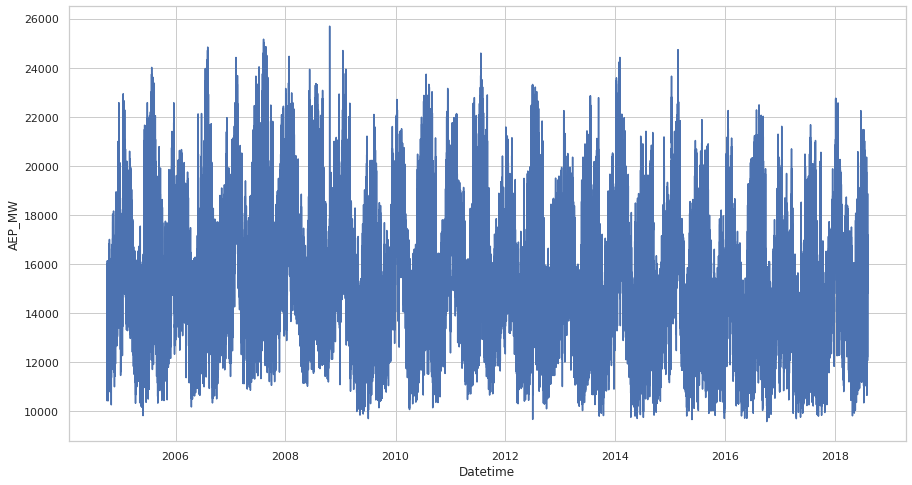

In [7]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='Datetime', y='AEP_MW')

Memilih Data Setahun Terakhir
Pada contoh ini kita hanya akan gunakan data setahun terakhir dari data AEP_hourly
Karena data yang diobservasi per jam, maka kita akan mengambil 24*365=8760 baris terakhir dari df dan dimasukan kedalam variabel df1


In [8]:
df1 = df[-24*365:].reset_index(drop=True)
df1.head()

,Datetime,AEP_MW
0,2017-08-03 01:00:00,13682.0
1,2017-08-03 02:00:00,12841.0
2,2017-08-03 03:00:00,12443.0
3,2017-08-03 04:00:00,12213.0
4,2017-08-03 05:00:00,12286.0


Plot Data df1


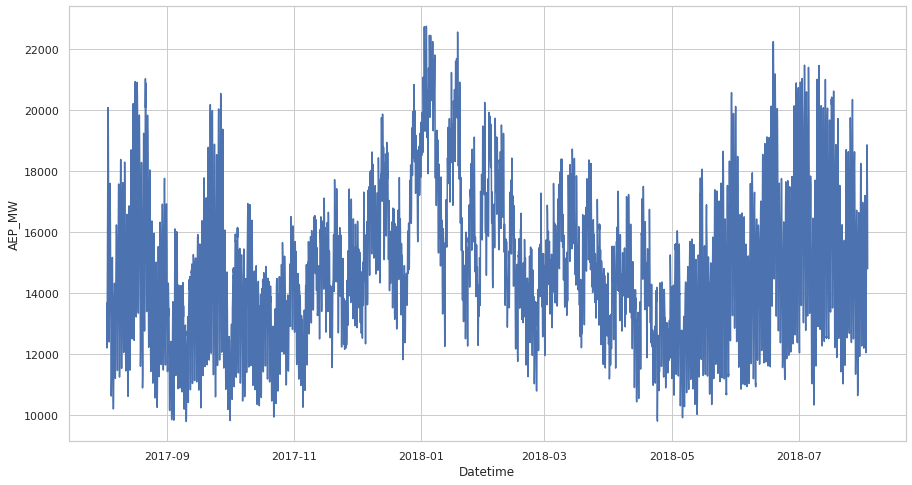

In [9]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df1, x='Datetime', y='AEP_MW')

Melihat Statistika Deskriptif dari Data
Sebelum melakukan pembuatan model, sebaiknya dilakukan analisa terhadap statistika deskriptif dari data
Dari statistika deskriptif tersebut, kita dapat meilhat range dari data dan ukuran pusat data


In [10]:
df1.describe()

,AEP_MW
count,8760.000000
mean,14963.130708
std,2438.848843
min,9801.000000
25%,13260.750000
50%,14721.500000
75%,16421.750000
max,22759.000000


Dari statistika deskriptif di atas terlihat bahwa data AEP_MW cukup besar dan berada pada range 9801 dan 22759 sehingga nanti kita akan lakukan feature scalling menggunakan MinMaxScaler agar range dari seluruh data tersebut berada di antara 0 dan 1

List normalisasi yang tersedia oleh sklearn : https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html




### Split Data


Split data dilakukan agar model yang telah dilatih dapat dievaluasi kemampuannya.
Karena data yang digunakan adalah data time series, maka split data tidak dilakukan secara acak
Kita juga akan melakukan cross validation menggunakan data train sehingga pastikan data train yang digunakan cukup besar.
Pada contoh ini kita gunakan 70% baris pertama sebagai data train dan 30% sisanya sebagai data test.

In [11]:
# split data
train_size = int(len(df1) * 0.7) # Menentukan banyaknya data train yaitu sebesar 70% data
train = df1[:train_size]
test =df1[train_size:].reset_index(drop=True)

Feature Scalling Menggunakan MinMaxScaler
MinMaxScaler difit pada data train agar dapat digunakan kembali pada data test maupun data observasi baru.
Hasil scalling disimpan pada kolom baru yaitu 'scaled'


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['AEP_MW']])

train['scaled'] = scaler.transform(train[['AEP_MW']])
test['scaled'] = scaler.transform(test[['AEP_MW']])

Mari kita lihat 5 data pertama pada data train untuk melihat data yang sudah discalling

In [13]:
train.head()

,Datetime,AEP_MW,scaled
0,2017-08-03 01:00:00,13682.0,0.299506
1,2017-08-03 02:00:00,12841.0,0.234604
2,2017-08-03 03:00:00,12443.0,0.203889
3,2017-08-03 04:00:00,12213.0,0.186140
4,2017-08-03 05:00:00,12286.0,0.191773


Membuat fungsi sliding window
Selanjutnya kita akan membuat fungsi sliding window dengan input data (bertipe data numpy array) dan window size
Fungsi ini akan menghasilkan variabel input (X) dan variabel target (y)

In [14]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

Berapa window size yang tepat untuk digunakan?
Pada penerapannya kita dapat menentukan window size berapa saja.
Untuk mencapai hasil yang maksimal dapat dilakukan percobaan dengan menggunakan beberapa window size.
Perlu diperhatikan juga bahwa semakin** besar window size **yang digunakan akan memerlukan waktu yang cukup lama dalam proses training data
Pada contoh ini kita hanya menggunakan window size = 24 atau sama dengan 1 hari dan kita terapkan pada data train dan test yang telah discalling

In [15]:
window_size = 24

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)

Penting!!!
Data input LSTM harus 3D : [samples, timesteps, feature]
Maka dari itu kita perlu cek dimensi data kita menggunakan np.shape

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6108, 24, 1) (6108, 1)
(2604, 24, 1) (2604, 1)


## LSTM menggunakan Tensorflow dan Keras
tensorflow: https://www.tensorflow.org/overview
keras: https://keras.io/about/

Untuk membuat LSTM() layer menggunakan Keras, perhatikan parameter-parameter berikut untuk membuat LSTM layer sederhana, ada beberapa parameter yaitu 


*   units: menentukan banyaknya LSTM unit
*   input_shape: menentukan ukuran timesteps dan feature, diperlukan pada layer pertama
*   return_sequences: jika layer berikutnya berupa LSTM layer maka return_sequences=True (default = False)


Paramaeter-parameter lainnya dapat dilihat pada link berikut: https://keras.io/api/layers/recurrent_layers/lstm/



# Membuat Model Forecasting Menggunakan LSTM

Untuk menggunakan arsitektur GRU, ganti model LSTM dengan RNN atau GRU

# 1. Import Modul

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM #, RNN, GRU 

# 2. Membuat Fungsi Model Forecasting Menggunakan LSTM
Fungsi model yang akan dibuat terdiri:

LSTM layer dengan 
* input_shape = (window_size, 1)
* Dense layer dengan 32 neuron dengan fungsi aktivasi ReLu
* Dropout antara Dense layer dan Dense output layer
* Dense output layer dengan 1 neuron
* loss function yang digunakan adalah Mean Squared Error (MSE)
* optimizer yang digunakan adalah adam
* metric yang digunakan adalah Mean Absolute Error (MAE)

* Parameter-parameter yang dijadikan sebagai input dari fungsi tersebut adalah:
  - LSTM_unit: banyaknya LSTM unit (default = 64)
  - dropout: persentase dropout (default = 0.2)

In [18]:
def create_model(LSTM_unit=64, dropout=0.2): #jika ingin menggunakan RNN atau GRU ganti LSTM dengan GRU/RNN
    # create model
    model = Sequential()
    model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

#3. Membuat Model
Kita coba lakukan hypertuning pada parameter, dengan mencoba kombinasi nilai LSTM unitnya 16,32,64,28 dan peluang dropout 0,1 dan 0,2



In [19]:
LSTM_unit = [16,32,64,128]
dropout = [0.1,0.2]

Selain itu, kita juga gunakan early stopping pada saat proses training



In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=1)

# define the grid search parameters
LSTM_unit = [16,32,64,128]
dropout=[0.1,0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

# 4. Membuat Variabel GridSearchCV
Variabel GridSearchCV dibuat dengan memasukan beberapa parameter yaitu:
- estimator: model yang ingin dilakukan gridsearch
- param_grid: parameter yang ingin diuji
- n_jobs: Jumlah pekerjaan untuk dijalankan secara paralel. (-1 artinya menggunakan seluruh core processor)
- cv: banyaknya k-fold cross validation

In [21]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

# 5. Training Model dengan GridSearchCV



In [22]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
172/172 [==============================] - 5s 14ms/step - loss: 0.0187 - mae: 0.1037 - val_loss: 0.0038 - val_mae: 0.0490
Epoch 2/50
172/172 [==============================] - 2s 11ms/step - loss: 0.0073 - mae: 0.0657 - val_loss: 0.0026 - val_mae: 0.0396
Epoch 3/50
172/172 [==============================] - 2s 11ms/step - loss: 0.0052 - mae: 0.0550 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 4/50
172/172 [==============================] - 2s 11ms/step - loss: 0.0043 - mae: 0.0492 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 5/50
172/172 [==============================] - 2s 10ms/step - loss: 0.0034 - mae: 0.0435 - val_loss: 9.2743e-04 - val_mae: 0.0230
Epoch 6/50
172/172 [==============================] - 2s 10ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 9.3377e-04 - val_mae: 0.0233
Epoch 7/50
172/172 [==============================] - 2s 10ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 7.9903e-04 - val_mae: 0.0216
Epoch 8/50
172/172 [==============================] - 2s 

# 6. Melihat Hasil Parameter Terbaik


In [23]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.000333 using {'LSTM_unit': 128, 'dropout': 0.1}
-0.000463 (0.000059) with: {'LSTM_unit': 16, 'dropout': 0.1}
-0.000457 (0.000105) with: {'LSTM_unit': 16, 'dropout': 0.2}
-0.000374 (0.000035) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.000468 (0.000146) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.000445 (0.000095) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.000550 (0.000190) with: {'LSTM_unit': 64, 'dropout': 0.2}
-0.000333 (0.000053) with: {'LSTM_unit': 128, 'dropout': 0.1}
-0.000349 (0.000040) with: {'LSTM_unit': 128, 'dropout': 0.2}


Dari Hasil Training menggunakan GridSearchCV, kita peroleh:

parameter terbaiknya adalah: {'LSTM_unit': 128, 'dropout': 0.2}
Rata-rata Loss Function dari hasil Cross Validation adalah 0.000353
Kemudian coba kita lihat grafik loss function MSE dan metric MAE terhadap epoch untuk melihat performa model terbaik kita dengan cara sebagai berikut

Kita dapat melihat grafik loss function MSE dan metric MAE terhadap epoch untuk melihat performa model kita dengan cara sebagai berikut


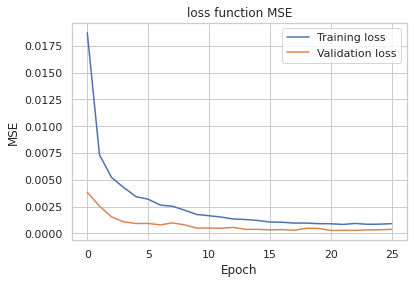

In [24]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

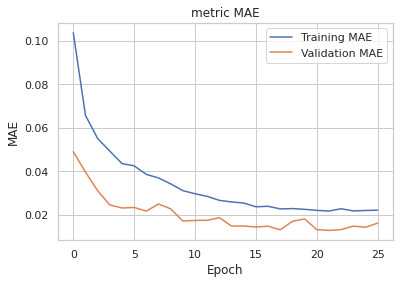

In [25]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# 7. Evaluasi Model
Melakukan prediksi pada data train dan data test

In [26]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

Plot prediksi data train


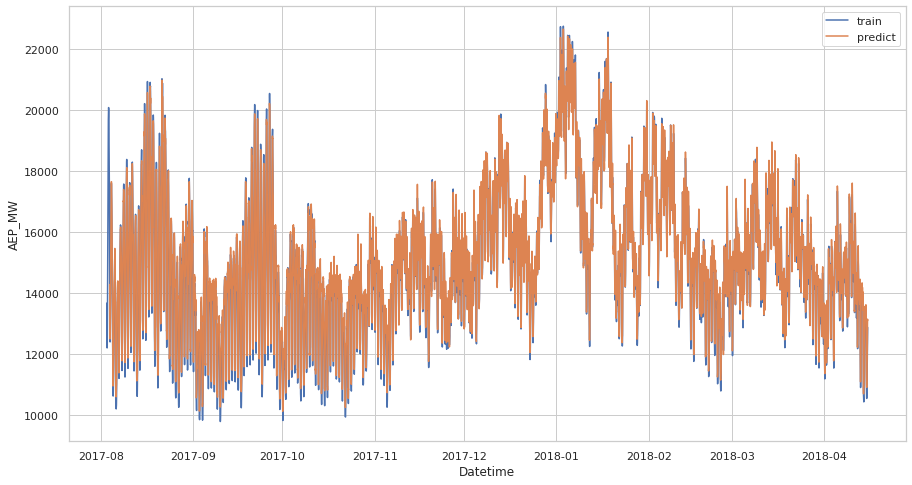

In [27]:
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='Datetime', y='AEP_MW', label = 'train')
sns.lineplot(data=train, x='Datetime', y='predict', label = 'predict')

Plot prediksi data test

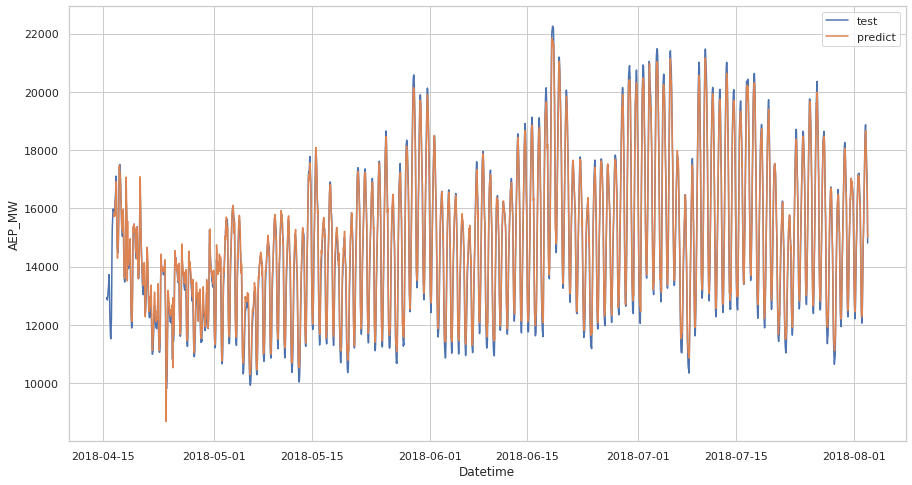

In [28]:
test['predict'] = np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='Datetime', y='AEP_MW', label = 'test')
sns.lineplot(data=test, x='Datetime', y='predict', label = 'predict')

Plot prediksi data test sebulan terakhir

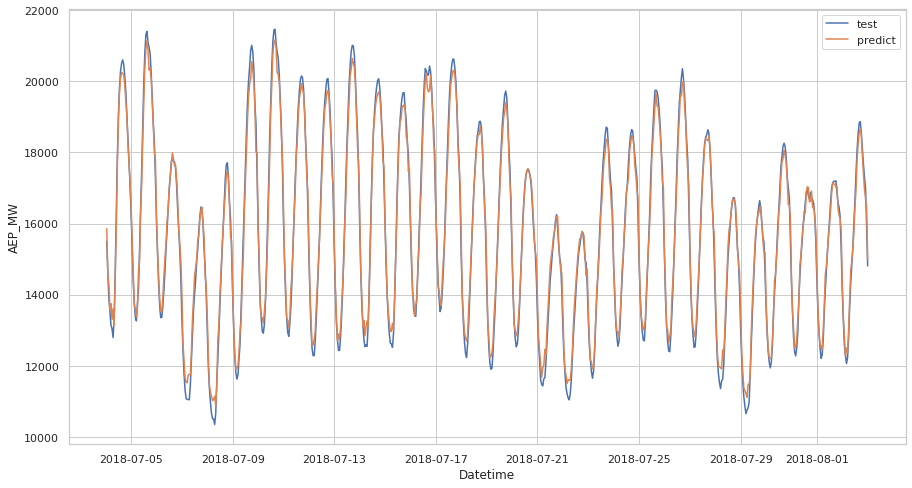

In [29]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-24*30:], x='Datetime', y='AEP_MW', label = 'test')
sns.lineplot(data=test[-24*30:], x='Datetime', y='predict', label = 'predict')

Melakukan forecasting

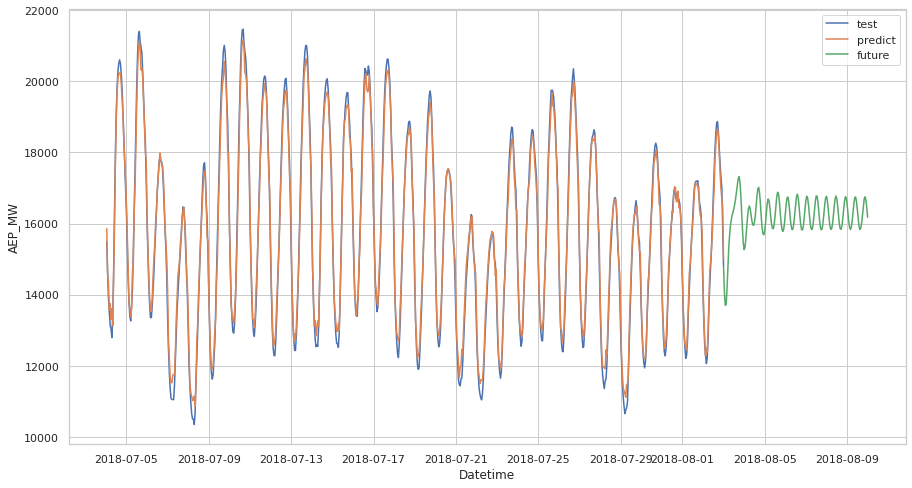

In [30]:
# forecasting data selanjutnya
y_test = scaler.transform(test[['AEP_MW']])
n_future = 24*7
future = [[y_test[-1,0]]]
X_new = y_test[-window_size:,0].tolist()

for i in range(n_future):
    y_future = best_model.predict(np.array([X_new]).reshape(1,window_size,1))
    future.append([y_future[0,0]])
    X_new = X_new[1:]
    X_new.append(y_future[0,0])

future = scaler.inverse_transform(np.array(future))
date_future = pd.date_range(start=test['Datetime'].values[-1], periods=n_future+1, freq='H')
# Plot Data sebulan terakhir dan seminggu ke depan
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-24*30:], x='Datetime', y='AEP_MW', label = 'test')
sns.lineplot(data=test[-24*30:], x='Datetime', y='predict', label = 'predict')
sns.lineplot(x=date_future, y=future[:,0], label = 'future')
plt.ylabel('AEP_MW');
